<a href="https://colab.research.google.com/github/suchendra-h/traffic_sign/blob/master/Copy_of_Process_GTSRB_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip uninstall tensorflow
!pip install tensorflow==2.1


In [0]:
import tensorflow as tf
print(tf.__version__)

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
from PIL import Image
import os
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow_hub as hub
import matplotlib
import matplotlib.pyplot as plt
import zipfile, csv, random, pathlib, time
from google.colab import drive

################################################################################
drive.mount('/content/drive')


In [3]:
### prepare class lables from training and validation folders

training_data_dir = "/content/drive/My Drive/Colab Notebooks/dataset/training"
training_data_dir = pathlib.Path(training_data_dir)
image_count = len(list(training_data_dir.glob('*/*.jpg')))
tmp = np.array([item.name for item in training_data_dir.glob('*') if item.name != "LICENSE.txt"])
tmp = np.sort(tmp.astype(int))
training_class_names = np.array(['0000' + np.str(i) for i in tmp if i < 10] +\
['000' + np.str(i) for i in tmp if i >= 10])

### validation
tmp_validation_data_dir = "/content/drive/My Drive/Colab Notebooks/dataset/validation"
tmp_validation_data_dir = pathlib.Path(tmp_validation_data_dir)
tmp = np.array([item.name for item in tmp_validation_data_dir.glob('*') if item.name != "GT-final_test.csv"])
tmp = np.sort(tmp.astype(int))
validation_class_names = np.array(['0000' + np.str(i) for i in tmp if i < 10] +\
['000' + np.str(i) for i in tmp if i >= 10])

### prepare call back path
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/dataset/checkpoints/"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=1)

Found 26640 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 112, 112, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 43)                17260587  
Total params: 17,261,483
Trainable params: 17,261,483
Non-trainable params: 0
_________________________________________________________________
  ...
    to  
  ['...

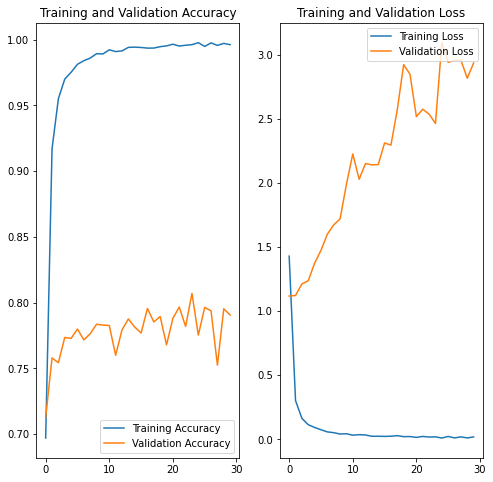

In [4]:
start = time.time()
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# image_gen_train = ImageDataGenerator(
#                     rescale=1./255,
#                     rotation_range=45,
#                     width_shift_range=.15,
#                     height_shift_range=.15,
#                     horizontal_flip=True,
#                     zoom_range=0.5
#                     )
validation_image_generator = ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
train_data_gen = image_generator.flow_from_directory(directory=str(training_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(training_class_names))
# train_data_gen = image_gen_train.flow_from_directory(directory=str(training_data_dir),
#                                                      batch_size=BATCH_SIZE,
#                                                      shuffle=True,
#                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
#                                                      classes = list(training_class_names))
validation_gen = validation_image_generator.flow_from_directory(directory=str(tmp_validation_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True   ,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(validation_class_names))
epochs = 30
model = models.Sequential()
model.add(layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.SpatialDropout2D(0.1))
#model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
#model.add(layers.MaxPooling2D())
#model.add(layers.SpatialDropout2D(0.1))
#model.add(layers.Conv2D(64, 3, padding='same',activation='relu'))
#model.add(layers.MaxPooling2D())
#model.add(layers.SpatialDropout2D(0.1))
#model.add(layers.UpSampling2D())
#model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
#model.add(layers.MaxPooling2D())
#model.add(layers.SpatialDropout2D(0.1))
model.add(Flatten())
#model.add(Dense(512, activation='relu'))
model.add(Dense(43))

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.build(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
model.summary()
# history = model.fit(labeled_training_ds, epochs=5, validation_data=(validation_images, validation_labels))
history = model.fit(train_data_gen, epochs=epochs,
                    validation_data=validation_gen,
                    callbacks=[cp_callback])
# save the model
saved_model_path = "/content/drive/My Drive/Colab Notebooks/dataset/saved_models"
model.save('saved_model/my_model')


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

end = time.time()
elapsed = end - start
print('elapesed time:  ', elapsed)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [0]:
cp_callback.

In [17]:
validation_class_names


array(['00000', '00001', '00002', '00003', '00004', '00005', '00006',
       '00007', '00008', '00009', '00010', '00011', '00012', '00013',
       '00014', '00015', '00016', '00017', '00018', '00019', '00020',
       '00021', '00022', '00023', '00024', '00025', '00026', '00027',
       '00028', '00029', '00030', '00031', '00032', '00033', '00034',
       '00035', '00036', '00037', '00038', '00039', '00040', '00041',
       '00042'], dtype='<U5')

In [18]:
training_class_names

array(['00000', '00001', '00002', '00003', '00004', '00005', '00006',
       '00007', '00008', '00009', '00010', '00011', '00012', '00013',
       '00014', '00015', '00016', '00017', '00018', '00019', '00020',
       '00021', '00022', '00023', '00024', '00025', '00026', '00027',
       '00028', '00029', '00030', '00031', '00032', '00033', '00034',
       '00035', '00036', '00037', '00038', '00039', '00040', '00041',
       '00042'], dtype='<U5')

In [30]:
history.history

{'accuracy': [0.6317568],
 'loss': [4.542879317311553],
 'val_accuracy': [0.67790973],
 'val_loss': [1.2747363804261895]}

In [29]:
model.evaluate(x=validation_gen)

  ...
    to  
  ['...']
395/395 [==============================] - 177s 449ms/step - loss: 1.2747 - accuracy: 0.6779


[1.2747363804261895, 0.67790973]

In [13]:
validation_gen.classes


array([], dtype=int32)